In [1]:
import pandas as pd
import numpy as np
import os

from PIL import Image
from matplotlib.pyplot import imshow

In [2]:
# Analysis:
# essential fields for the segmentation task are: id (sample id), annotation (cell area in rle format), cell_type
# the segmentation shall be performed on the whole image
# thus the annotations of the same cell_type shall be aggregated to a single annotation mask
# The image width and heights shall be preserved for sanity check. 

In [68]:
class DataSet:
    def __init__(self, data_path):
        self.data_path = data_path
        self.data_instance_shape = (0, 0)
        self.data = pd.read_csv(os.path.join(self.data_path, 'train.csv'))
        self.preprocess()
        
    def preprocess(self):
        to_be_dropped = ['plate_time', 'sample_date', 'sample_id', 'elapsed_timedelta', 'width', 'height']
        group_index = ['id', 'cell_type']
        self.data_instance_shape = (self.data.iloc[0]['height'], self.data.iloc[0]['width'])
        def transform(annotation):
            return list(map(lambda xx: int(xx), ' '.join(str(e) for e in list(annotation)).split(' ')))
        self.data = self.data.drop(columns=to_be_dropped).groupby(group_index).agg(transform).reset_index()
        
    def get_sample(self, index):
        path = os.path.join(self.data_path, 'train', self.data.iloc[index]['id'] + '.png')
        return np.asarray(Image.open(path))
 
    def get_annotation(self, index):
        result = np.zeros(self.data_instance_shape[0] * self.data_instance_shape[1], dtype=np.uint)
        state = 0
        for token in self.data.iloc[index]['annotation']:
            if state == 0:
                state = 1
                index = token
            else:
                state = 0
                num_iterations = token
                for offset in np.arange(num_iterations):
                    result[index + offset - 1] = 1
        return result.reshape(self.data_instance_shape)
    
    def __len__(self):
        return len(self.data)

ds = DataSet('./')

In [69]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

In [70]:

class ImSeg(keras.utils.Sequence):
    def __init__(self, batch_size, data_set):
        self.batch_size = batch_size
        self.data_set = data_set

    def __len__(self):
        return len(self.data_set) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        x = np.zeros((self.batch_size,) + self.data_set.data_instance_shape + (1,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.data_set.data_instance_shape + (1,), dtype="uint8")
        
        for ii in np.arange(self.batch_size):
            index = idx * self.batch_size + ii
            x[ii] = np.expand_dims(self.data_set.get_sample(index), 2)
            y[ii] = np.expand_dims(self.data_set.get_annotation(index), 2)
        
        return x, y
    
# aa = ImSeg(5, ds)
#x, y = aa.__getitem__(1)

In [71]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    
    
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(ds.data_instance_shape, 2)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 520, 704, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 260, 352, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 260, 352, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 260, 352, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [74]:


train_gen = ImSeg(
    4, ds
)
#val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


In [77]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
#model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
model.fit(train_gen, epochs=1, callbacks=callbacks)


151/151 [==============================] - 1165s 8s/step - loss: 0.2422


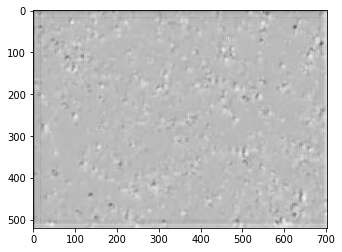

In [105]:


imshow(Image.fromarray(model.predict(train_gen.__getitem__(1)[0])[0,:,:,0]*255))


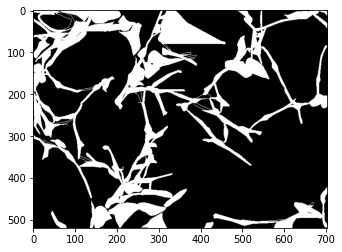

In [104]:
imshow(Image.fromarray(ds.get_annotation(1)*255))